Import packages

In [1]:
# import time to record time for each processing phase
from time import time

# import sys and os to gain access to local repo
import sys
import os

# import tensorflow and keras module to build CNN
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, regularizers, utils, optimizers, callbacks, optimizers, backend
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization, Conv2D, MaxPooling2D
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# import Pillow to work on image
from PIL.Image import fromarray

# import numpy for calculation support
import numpy as np

#import pandas for output model history and scores
import pandas as pd

#import scipy for data standardization
from scipy.stats import zscore

# import matplotlib to visualize
import matplotlib as mpl
import matplotlib.pyplot as plt

Loading cifar10 dataset, and split training and testing dataset

In [2]:
#load and split training and testing data
(train_img, train_lb), (test_img, test_lb) = datasets.cifar10.load_data()

create label names from the metadata of cifar-10 (for visualization)

In [3]:
lb_name = {0: 'airplane', 1: 'automobile', 2:'bird', 3: 'cat', 4: 'deer', 5: 'dog', 6: 'frog', 7: 'horse', 8: 'ship', 9: 'truck'}

visualizing data

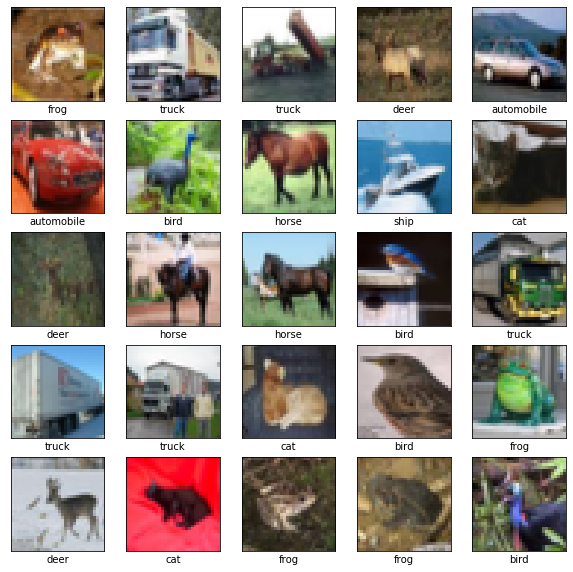

In [4]:
mpl.rcParams['figure.figsize'] = (12, 5)
plt.figure(figsize = (10, 10))

for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_img[i], cmap = plt.cm.binary)
    plt.xlabel(lb_name[train_lb[i][0]])
plt.show()

Because cifar10 dataset is float64 array, we convert image data into float32 for ease of processing

In [5]:
train_img = train_img.astype('float32')
test_img = test_img.astype('float32')

Then we apply standardization to image data for ease of processing

In [6]:
t0 = time()
train_img = zscore(train_img, axis = None)
test_img = zscore(test_img, axis = None)
dur = time() - t0
print("Standardization takes %fs" % dur)

Standardization takes 1.947277s


convernt target lable into categorical variable for classification

In [7]:
num_lb = 10
train_lb = utils.to_categorical(train_lb, num_lb)
test_lb = utils.to_categorical(test_lb, num_lb)

Built a simple 2-layer CNN to get a base performance on this dataset

In [8]:
# build a 2 layer basic CNN to get a base performance estimation
base_model = Sequential([
    Conv2D(32, (3, 3), activation = 'relu', input_shape = (32, 32, 3)),
    MaxPooling2D((2,2)),
    Flatten(),
    Dense(num_lb, activation = 'softmax'),
])

# output our model structure
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 7200)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                72010     
Total params: 72,906
Trainable params: 72,906
Non-trainable params: 0
_________________________________________________________________


Fit, test, and evaluate the 2-layer CNN to quantify base performance

In [9]:
'''
using adam as out optimizer, because it is "computationally efficient, has little memory requirement, 
invariant to diagonal rescaling of gradients, and is well suited for porblems that are large in terms
of data and/parameters", according to Kingma et al.'s (2014) paper. Adam well suits CNN due to the huge
amount of parameters involved.
We will leave the default parameter of Adam as keras documents adviced (lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-07).
'''
optimizer = optimizers.Adam()

'''
using a callback function to store early stopping condition, this is just for saving computation time.
minimum increase is set to 0.001, patience is 10 epochs. This means if more than 10 epochs the monitored
validation loss is not decreasing more than 0.001, then stop training. We also set restore_best_weights 
to true after some experiment. Because if this parameter is set to false, the model will only output the 
validation accuracy from the last epoch, which usually not the best accuracy.
'''
early_stop = callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 1e-3, patience = 10, restore_best_weights = True)

base_model.compile(optimizer = optimizer,
              loss = 'categorical_crossentropy', # we use categorical crossentropy loss here
              metrics=['accuracy']) 
'''
To increase the efficiency of computing, we use batches of 500 images each step every epoch. The fitting
proccess will run 200 epoch, and will early stop if there is no further decrease of validation loss after
10 epochs. We use holdout validation to check model performance.
'''
base_t0 = time()

base_report = base_model.fit(train_img,
                   train_lb,
                   steps_per_epoch = train_img.shape[0] // 500,
                   epochs = 200,
                   validation_data=(test_img, test_lb),
                   callbacks = [early_stop],
                   use_multiprocessing = True)

base_train_time = time() - base_t0 #output total training time for base model

base_test_loss, base_test_acc = base_model.evaluate(test_img, test_lb, verbose=1) #output test loss and test accuracy for base model

Train on 50000 samples, validate on 10000 samples
Epoch 1/200
50000/50000 [==============================] - 10s 193us/sample - loss: 1.6521 - accuracy: 0.4254 - val_loss: 1.3941 - val_accuracy: 0.5213
Epoch 2/200
50000/50000 [==============================] - 9s 187us/sample - loss: 1.3044 - accuracy: 0.5491 - val_loss: 1.2766 - val_accuracy: 0.5573
Epoch 3/200
50000/50000 [==============================] - 9s 187us/sample - loss: 1.1847 - accuracy: 0.5928 - val_loss: 1.1933 - val_accuracy: 0.5879
Epoch 4/200
50000/50000 [==============================] - 9s 187us/sample - loss: 1.1011 - accuracy: 0.6218 - val_loss: 1.1238 - val_accuracy: 0.6131
Epoch 5/200
50000/50000 [==============================] - 9s 187us/sample - loss: 1.0450 - accuracy: 0.6438 - val_loss: 1.0975 - val_accuracy: 0.6195
Epoch 6/200
50000/50000 [==============================] - 9s 188us/sample - loss: 0.9981 - accuracy: 0.6566 - val_loss: 1.0755 - val_accuracy: 0.6300
Epoch 7/200
50000/50000 [==================

after getting the base performance of a two-layer CNN, we choose to visualize the convergence of gradient to its optima.

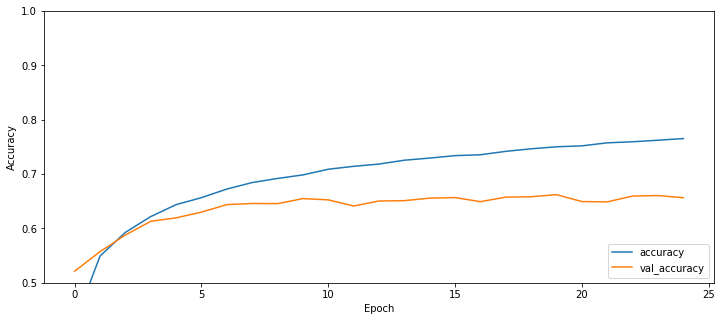

In [10]:
plt.plot(base_report.history['accuracy'], label='accuracy')
plt.plot(base_report.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

Build a deeper CNN to see if we can improve the prediction accuracy

In [11]:
'''
We have tested one layer model with large width, it starts to overfit data over a few epoch. Thus we
decide to build a deeper model.

After trying different number of layers and combination of them, and reading a blog post about how to
reach 90% accuracy on cifar-10 dataset using CNN, we decide to adopt similar architecture as the blog post,
since it yields the highest accuracy among different architectures we tested.

However, build a deep CNN with padded Conv2D and maxpooling layer is very easy to overfit, which reflected
by validation loss going up after a few epochs when training loss continuously going down. Thus, we
decided to add the regulization to our layer, such as l2 regulization for Conv2D layers, batch normalization layers after each Conv2D layer, and dropout layers after each increment of kernel size.
When tuning the parameter of normalization function, we cannot reach higher accuracy than the blog post
thus we adapted their parameter for l2 regularization and dropout layer. In addition, we observe less 
validation accuracy if useing only one regularization method, due to the model's high potential of 
overfitting the training data.
'''
model = Sequential([
    Conv2D(32, (3, 3), activation = 'relu', padding = 'same', kernel_regularizer = regularizers.l2(1e-4), input_shape = (32, 32, 3)),
    BatchNormalization(),
    Conv2D(32, (3, 3), activation = 'relu', padding = 'same', kernel_regularizer = regularizers.l2(1e-4)),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation = 'relu', padding = 'same', kernel_regularizer = regularizers.l2(1e-4)),
    BatchNormalization(),
    Conv2D(64, (3, 3), activation = 'relu', padding = 'same', kernel_regularizer = regularizers.l2(1e-4)),
    BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation = 'relu', padding = 'same', kernel_regularizer = regularizers.l2(1e-4)),
    BatchNormalization(),
    #Conv2D(128, (3, 3), activation = 'relu', padding = 'same', kernel_regularizer = regularizers.l2(1e-4)),
    #BatchNormalization(),
    MaxPooling2D((2,2)),
    Dropout(0.4),

    Flatten(),
    Dense(num_lb, activation = 'softmax')
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 64)       

Build a augmentate dataset using ImageDataGenerator function from Tensorflow

In [12]:
'''
Initialize a image generator from keras to add noise to training images. 
In this generator, we will rotate our images randomlly within 15 degrees, the width and height of the 
image will randomlly shift 100 percent. Images also will be randomlly zoomed within 10 percent. The final
output image data type is float32, the same as our original data.
'''
aug = ImageDataGenerator(
    rotation_range = 15,
    width_shift_range = 0.1, 
    height_shift_range = 0.1, 
    #horizontal_flip = True, 
    #vertical_flip = True, 
    zoom_range = 0.1, 
    dtype = 'float32') 

# feed original training image into augmentation function
aug.fit(train_img)

fit, test, and evaluate our deep model to check if there is a increased accuracy.

In [13]:
'''
using adam as out optimizer, because it is "computationally efficient, has little memory requirement, 
invariant to diagonal rescaling of gradients, and is well suited for porblems that are large in terms
of data and/parameters", according to Kingma et al.'s (2014) paper. Adam well suits CNN due to the huge
amount of parameters involved.
We will leave the default parameter of Adam as keras documents adviced (lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-07).
'''
optimizer = optimizers.Adam()

'''
using a callback function to store early stopping condition, this is just for saving computation time.
minimum increase is set to 0.001, patience is 10 epochs. This means if more than 10 epochs the monitored
validation loss is not decreasing more than 0.001, then stop training. We also set restore_best_weights 
to true after some experiment. Because if this parameter is set to false, the model will only output the 
validation accuracy from the last epoch, which usually not the best accuracy.
'''
early_stop = callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0.001, patience = 10, restore_best_weights = True)

model.compile(optimizer = optimizer,
              loss = 'categorical_crossentropy', # we use categorical crossentropy loss here
              metrics=['accuracy']) 
'''
We use holdout validation to test model performance. Running total 200 epoch to search for best model, 
but with early stopping if validation loss stops to decrease more than 10 epoch. We divide our dataset into batches with 500 images.
'''
deep_t0 = time()

report = model.fit(aug.flow(train_img, train_lb, batch_size = 500), 
                   steps_per_epoch = train_img.shape[0] // 500,
                   epochs = 200,
                   validation_data=(test_img, test_lb),
                   callbacks = [early_stop])

deep_train_time = time() - base_t0 #output total training time for deep model

test_loss, test_acc = model.evaluate(test_img, test_lb, verbose=1) #output test loss and test accuracy for deep model

  ...
    to  
  ['...']
Train for 100 steps, validate on 10000 samples
Epoch 1/200
100/100 [==============================] - 116s 1s/step - loss: 2.2095 - accuracy: 0.3417 - val_loss: 2.1994 - val_accuracy: 0.1897
Epoch 2/200
100/100 [==============================] - 117s 1s/step - loss: 1.6530 - accuracy: 0.4605 - val_loss: 2.1558 - val_accuracy: 0.2598
Epoch 3/200
100/100 [==============================] - 118s 1s/step - loss: 1.4546 - accuracy: 0.5174 - val_loss: 1.5813 - val_accuracy: 0.4582
Epoch 4/200
100/100 [==============================] - 118s 1s/step - loss: 1.3654 - accuracy: 0.5542 - val_loss: 1.0583 - val_accuracy: 0.6427
Epoch 5/200
100/100 [==============================] - 119s 1s/step - loss: 1.2317 - accuracy: 0.5948 - val_loss: 1.1208 - val_accuracy: 0.6129
Epoch 6/200
100/100 [==============================] - 119s 1s/step - loss: 1.1674 - accuracy: 0.6187 - val_loss: 1.0121 - val_accuracy: 0.6630
Epoch 7/200
100/100 [==============================] - 119s 1s/s

Visualize base and deep CNN performance for better comparison, output the graph

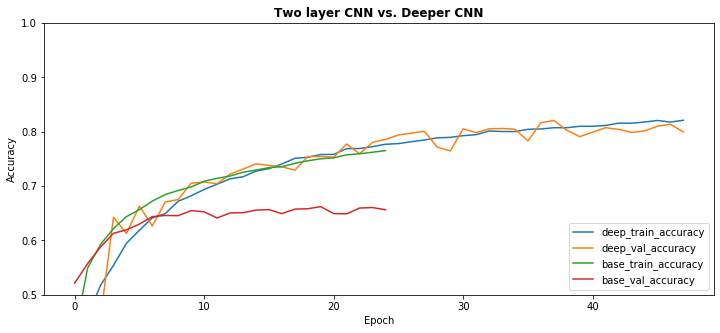

In [14]:
plt.plot(report.history['accuracy'], label = 'deep_train_accuracy')
plt.plot(report.history['val_accuracy'], label = 'deep_val_accuracy')
plt.plot(base_report.history['accuracy'], label = 'base_train_accuracy')
plt.plot(base_report.history['val_accuracy'], label = 'base_val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc = 'lower right')
plt.title('Two layer CNN vs. Deeper CNN', fontweight = 'bold')
plt.savefig('CNN_compare.png', dpi = 300)

Output train/test accuracy at every epoch for base and deep CNN models

In [15]:
his_base_report = {'Epoch': np.arange(1, len(base_report.history['accuracy']) + 1, dtype = int), 'Base model train accuracy': base_report.history['accuracy'], 'Base model test accuracy': base_report.history['val_accuracy']}
his_deep_report = {'Epoch': np.arange(1, len(report.history['accuracy']) + 1, dtype = int), 'Deep model train accuracy': report.history['accuracy'], 'Deep model test accuracy': report.history['val_accuracy']}
time_acc = {'Base model training time': base_train_time, 'Base model performance': base_test_acc, 'Deep model training time': deep_train_time, 'Deep model performance': test_acc}

In [25]:
result_base = pd.DataFrame(data = his_base_report, columns = his_base_report.keys())
result_deep = pd.DataFrame(data = his_deep_report, columns = his_deep_report.keys())
result_comp = result_deep.merge(result_base, how = 'left', left_on = 'Epoch', right_on = 'Epoch')
result_time_acc = pd.DataFrame(data = time_acc, index = np.arange(1), columns = time_acc.keys(), dtype = 'float32')

In [28]:
result_comp.to_csv('CNN_comp_out.csv', index = False)
result_time_acc.to_csv('CNN_out_ttime_acc.csv', index = False)